In [319]:
import pandas as pd
import numpy as np
from util.cer_util import CER
import util.theory as theory
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import fsolve
import time

In [334]:
fitdf = pd.read_csv('./data/fit_data/narrow_lowpitch_fixedsig_fit_data.csv')

,mpv,eta,sigma,A,e_min,e_max,rmse
0,1.745721,0.070517,0.137641,17594.436216,1.000000,1.521592,42.784879
1,1.753779,0.071828,0.137641,17327.916645,1.521592,2.052678,42.183982
2,1.777051,0.072956,0.137641,17016.309209,2.052678,2.597759,43.386202
3,1.788119,0.074535,0.137641,17008.016786,2.597759,3.144185,41.653107
4,1.794918,0.075978,0.137641,16642.923989,3.144185,3.798715,45.001545
5,1.804564,0.076751,0.137641,16039.573711,3.798715,4.497364,45.366568
6,1.818009,0.075473,0.137641,16533.877802,4.497364,5.437525,49.330736
7,1.825457,0.076237,0.137641,16527.934803,5.437525,6.691661,49.447265
8,1.841005,0.075271,0.137641,16525.938605,6.691661,8.286596,44.555778
9,1.843937,0.074825,0.137641,16540.713939,8.286596,9.999993,49.872391


In [300]:
langau_params = fitdf[['mpv', 'eta', 'sigma']]
rng = np.random.default_rng()

### Proof of correct invese transform sampling

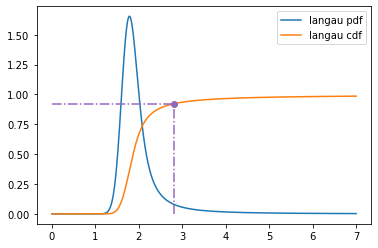

In [283]:
params = langau_params.iloc[0]
xrange = np.linspace(0,7,1000)

def sample_from_langau(mpv, eta, sigma):
    prob = rng.uniform()
    to_solve = lambda b: quad(theory.langau_pdf, -np.inf, b, args=(mpv, eta, sigma))[0]-prob
    dedx = fsolve(to_solve, 2)[0]
    return prob, dedx

plt.plot(xrange, [ theory.langau_pdf(x, *params) for x in xrange ], label='langau pdf')
plt.plot(xrange, [ quad(theory.langau_pdf, -np.inf, x, args=tuple(params))[0] for x in xrange ], label='langau cdf')
plt.legend()

prob, dedx = sample_from_langau(*params)

plt.plot([0, dedx], [prob,prob], ls='-.', color='tab:purple')
plt.plot([dedx, dedx], [0, prob], ls='-.', color='tab:purple')
plt.plot([dedx], [prob], marker='o', color='tab:purple')

### Generate distribution from which to sample MC track lengths
Uses a lognormal distribution which is fit to the track length histogram in the narrow lowpitch data. This takes a long time as the full dataset must be loaded, so it is only done and the fit values are hardcoded.

In [202]:
%%script false --no-raise-error
cer = CER(full=True, pitch_lims=(0.3, 0.4), angle_given=False, e_lims=(1, 10))
cer.load_muons()
lens = []
for i in cer.muons.index:
    lens.append(cer.muons.dedx_y.loc[i].shape[0])

In [228]:
import scipy.stats
from scipy.optimize import curve_fit

def lognorm(x, s, loc, scale):
    return scipy.stats.lognorm.pdf(x, s, loc, scale)

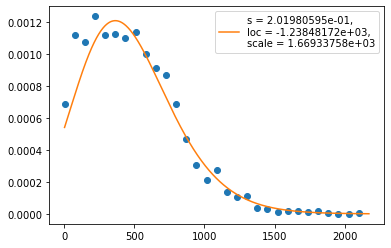

In [329]:
counts, edges = np.histogram(lens, 30, density=True)
bins = (edges[1:] + edges[:-1]) / 2
plt.plot(edges[:-1], counts, ls='', marker='o')
popt, pcov = curve_fit(lognorm, bins, counts)

x = np.linspace(edges[0], edges[-1], 1000)
plt.plot(x, lognorm(x, *popt), label='s = {:.8e}, \nloc = {:.8e}, \nscale = {:.8e}'.format(*popt))
plt.legend()
plt.show()

Here we hardcode the data distirubution data from the legend into these parameters, to avoid the long process every time

In [265]:
#                 s               loc              scale             
s, loc, scale = ( 2.01980595e-01, -1.23848172e+03, 1.66933758e+03 )

def rand_trkl():
    val = int(scipy.stats.lognorm.rvs(s, loc, scale))
    while val < 2:
        val = int(scipy.stats.lognorm.rvs(s, loc, scale))
    return val

Proof that this function is accurately reproducing the track length results:

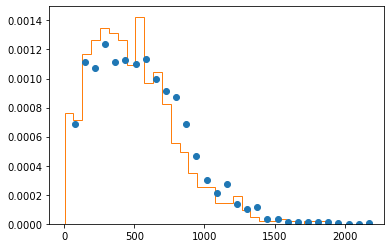

In [276]:
plt.plot(edges[1:], counts, ls='', marker='o')
plt.hist([rand_trkl() for x in range(1000)], bins=30, density=True, histtype='step')
plt.show()

Now we are ready for the MC data production, will make 200 muons in each of the energy bins, select a random track length for each, and for each data point in the track length, select a random dedx value distributed as that langau bin.

In [3]:
%%script false --no-raise-error

muons_per_ebin = 10
start = time.perf_counter()

dedxs_dict = {} 
for i, params in langau_params.iterrows():
    print('Bin '+ str(i) + '...')
    dedxs_per_ebin = []
    for j in range(muons_per_ebin):
        trkl = rand_trkl()
        
        dedxs = []
        for k in range(trkl):
            prob, dedx = sample_from_langau(*params)
            dedxs.append(dedx)
        
        dedxs_per_ebin.append(dedxs)
    dedxs_dict[str(i)] = dedxs_per_ebin
    
print('Generated!')
                 
end = time.perf_counter()
t = end-start
print(f'Total analysis time {int(t//60):d}m {t%60:.1f}s')

In [346]:
def like_max(dedxs):
    landau_params = np.array([ langau_params.iloc[i] for i in range(fitdf.shape[0]) ])
    
    # One big list comprehension for maximum calculation speed
    loglike = np.array([ np.sum([ np.log(theory.langau_pdf(xi, *fj_params)) - np.log(np.sum([ theory.langau_pdf(xi, *fk_params) for fk_params in landau_params])) for xi in dedxs ]) for fj_params in landau_params])
    
    jtilde = np.argmax(loglike)
    e_min_tilde, e_max_tilde = fitdf[['e_min', 'e_max']].iloc[jtilde]
    return e_min_tilde, e_max_tilde, loglike

In [348]:
truth = []
reconstructed = []
loglikes = []
p_count = 0

tot_particles = muons_per_ebin * fitdf.shape[0]
pcnt_per_count = 100./tot_particles
count_per_pcnt = 1/pcnt_per_count
running_count_for_pcnt_increment = 0

print("Generating elosses and reconstructing energy...")
start = time.perf_counter()
for key, value in dedxs_dict.items():
    
    for muon_dedxs in value:
        
        if p_count > running_count_for_pcnt_increment:
            print(f"{(running_count_for_pcnt_increment / tot_particles)*100:.0f}%   ", end = '\r', flush=True)
            running_count_for_pcnt_increment += count_per_pcnt

        p_count += 1
        e_min, e_max, loglike = like_max(muon_dedxs)

        true_e = fitdf[['e_min', 'e_max']].iloc[int(key)].mean()
        truth.append(true_e)

        guess_e = (e_min, e_max)
        reconstructed.append(guess_e)
        loglikes.append(loglike)
    
end = time.perf_counter()
t = end-start
print(f"Done! Analysis time: {int(t//60)}m {t%60:0.1f}s")

Generating elosses and reconstructing energy...
Done! Analysis time: 0m 39.3s


In [357]:
like_data_dict = []
for i in range(len(truth)):
    t = truth[i]
    re_min = reconstructed[i][0]
    re_max = reconstructed[i][1]
    
    this_dict = {'truth': t, 'reconstructed_min': re_min, 'reconstructed_max': re_max}
    
    for j in range(len(loglikes[i])):
        like = loglikes[i][j]
        this_dict[f'L{j}'] = like
    
    like_data_dict.append(this_dict)

save=False
if save:
    print("Saving likelihood data...")
    like_data = pd.DataFrame.from_dict(like_data_dict)
    like_data.to_csv(rf'../data/reconstructions/{save}', index=False, header=True)
    print('Saved!')